In [1]:
import sklearn
import librosa

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display as ipd
import librosa.display

array([-0.00766531, -0.01144071, -0.0094994 , ..., -0.00757105,
       -0.00910488,  0.        ], dtype=float32)

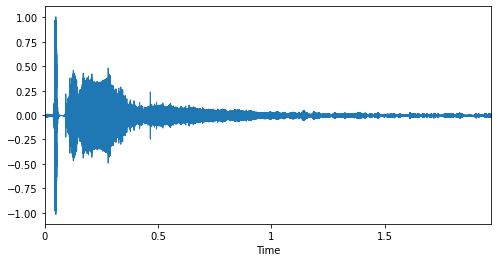

In [4]:
# sample_rate - частота дискредитации
# data - audio time series - звуко-временной ряд, записанный в массив
plt.figure(figsize=(8,4))
filename='/home/greygosling/Dataset_sound_recognition/Dataset/fold6/159704-6-0-0.wav'
data, sample_rate = librosa.load(filename)
librosa.display.waveplot(data, sr = sample_rate)
data

In [4]:
#Замена функциональности ipd.Audio(filename); баг с форматом WAV не позволяет проигрывать фрагмент аудио

import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

In [6]:
#Пример распознаваемого звука - выстрела
Audio(data, sample_rate)

In [7]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(filename)

array([[-18743296, -27000832],
       [-18808832, -27000832],
       [-19267584, -26345472],
       ...,
       [ -3932160, -32047104],
       [ -5373952, -31653888],
       [ -3801088, -32505856]], dtype=int32)

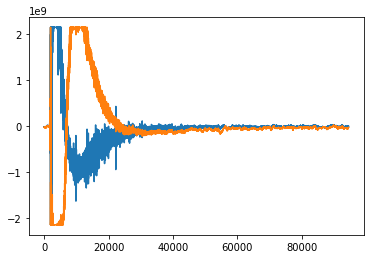

In [8]:
#The same audio example, but with who canals 
plt.plot(wave_audio)
wave_audio

In [9]:
import pandas as pd 
metadata = pd.read_csv('/home/greygosling/Dataset_sound_recognition/Dataset/UrbanSound8K.csv')
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [10]:
#Проверка датасета на сбалансированность
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [11]:
# MFCC - Mel-Frequency Cepstral Coefficients summarises the frequency 
# distribution across the window size, so it possible to analyse both 
# the frequency and the characteristics of the sound. These audio 
# representations will allow us to identify features for classification.
mfccs = librosa.feature.mfcc(y = data, sr = sample_rate, )
mfccs.shape

(20, 85)

In [12]:
mfccs

array([[-307.6415   ,   -1.8101953,   51.336853 , ..., -490.167    ,
        -489.96448  , -489.40567  ],
       [  57.7975   ,   59.491207 ,   59.648624 , ...,   88.20917  ,
          85.484116 ,   81.62944  ],
       [  10.69927  ,   -0.5010553,   -3.3296933, ...,   30.984303 ,
          29.653664 ,   28.550362 ],
       ...,
       [   1.7145908,    9.085733 ,    9.330689 , ...,    7.4017634,
           7.4753904,    4.9451256],
       [  13.533812 ,    5.164463 ,    4.8001122, ...,    6.7735896,
           6.8335304,    4.4686685],
       [   8.456127 ,    6.9279513,    7.2988853, ...,    2.3622928,
           3.1952703,    2.4676342]], dtype=float32)

In [13]:
# сбор фичь файла
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 46)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [14]:
audio_dataset_path='/home/greygosling/Dataset_sound_recognition/Dataset/'

In [15]:
from tqdm import tqdm
import os
#We iterate through every audio file and extract features using MFCC
extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold' + str(row["fold"]) + '/', str(row["slice_file_name"]))
    if os.path.exists(file_name) == 0:
        continue
    final_class_labels=row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3555it [05:52,  9.61it/s]/home/greygosling/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8325it [13:04, 15.04it/s]/home/greygosling/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
8329it [13:04, 20.30it/s]/home/greygosling/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [13:40, 10.64it/s]


In [16]:
# Converting extracted features to pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark
1,"[-424.68677, 110.56227, -54.14824, 62.01074, -...",children_playing
2,"[-459.56467, 122.80034, -47.92471, 53.265694, ...",children_playing
3,"[-414.55377, 102.896904, -36.664955, 54.18041,...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing


In [119]:
# Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())
X.shape

(8201, 46)

In [120]:
# Label Encoding
# Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [121]:
# Train test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [122]:
print(X_train.shape, '  ', X_test.shape, '  ', y_train.shape, '  ', y_test.shape)

(6560, 46)    (1641, 46)    (6560, 10)    (1641, 10)


In [123]:
# Dense – полносвязный слой;
# Dropout – слой, обнуляющий в модели НС часть весов;
# Flatten – слой, преобразующий 2D-данные в 1D-данные;
# Activation - функция активации;
# metrics - список метрик;
# sequental - последовательная модель;
# Adam - оптимизатор, необходимый для компиляции модели keras;

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [124]:
# number of classes
num_labels=y.shape[1]

In [125]:
# Характеристика обучения модели


model=Sequential()
# First layer
model.add(Dense(100, input_shape=(46,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [126]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               4700      
                                                                 
 activation_16 (Activation)  (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 200)               20200     
                                                                 
 activation_17 (Activation)  (None, 200)               0         
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_18 (Dense)            (None, 100)              

In [127]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [128]:
# Training model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer])

duration = datetime.now() - start
print('Training completed in time: ', duration)

Epoch 1/125
202/205 [============================>.] - ETA: 0s - loss: 13.3220 - accuracy: 0.1228
Epoch 00001: val_loss improved from inf to 2.27784, saving model to saved_models/audio_classification.hdf5
205/205 [==============================] - 1s 4ms/step - loss: 13.1783 - accuracy: 0.1226 - val_loss: 2.2778 - val_accuracy: 0.1304
Epoch 2/125
201/205 [============================>.] - ETA: 0s - loss: 2.7189 - accuracy: 0.1286
Epoch 00002: val_loss improved from 2.27784 to 2.27739, saving model to saved_models/audio_classification.hdf5
205/205 [==============================] - 1s 3ms/step - loss: 2.7134 - accuracy: 0.1294 - val_loss: 2.2774 - val_accuracy: 0.1249
Epoch 3/125
191/205 [==========================>...] - ETA: 0s - loss: 2.3702 - accuracy: 0.1327
Epoch 00003: val_loss improved from 2.27739 to 2.24960, saving model to saved_models/audio_classification.hdf5
205/205 [==============================] - 1s 3ms/step - loss: 2.3673 - accuracy: 0.1308 - val_loss: 2.2496 - val_ac

In [129]:
test_accuracy=model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.8104814291000366


In [5]:
# Данные для проверки
def Audio_play(file_name):
    temp_data, temp_sample_rate = librosa.load(file_name)
    return Audio(temp_data, temp_sample_rate)
Audio_play('/home/greygosling/Dataset_sound_recognition/Dataset/interesting_data.wav')

In [131]:
# from pydub import AudioSegment

# sound = AudioSegment.from_wav('/home/greygosling/Dataset_sound_recognition/Dataset/interesting_data.wav')

# def audio_slicing(sound):
#     fragments = []
#     temp = len(sound)
#     f_dot = 0.0
#     s_dot = 0.0
#     while True:
#         if temp <= 2000:
#             f_dot = s_dot
#             s_dot += temp
#             fragments.append(sound[f_dot:s_dot])
#             break
#         else:
#             f_dot = s_dot
#             s_dot += 2000
#             fragments.append(sound[f_dot:s_dot])
#             temp -= 2000
#     return fragments


    


In [132]:
# sound_sliced = audio_slicing(sound)
# def saver(audio_segment):
#     with open(audio_segment, "wb") as file:
#         file.write(audio.frame_data)

In [133]:
filename='/home/greygosling/Dataset_sound_recognition/Dataset/interesting_data.wav'
prediction_feature=features_extractor(filename)
prediction_feature=prediction_feature.reshape(1, -1)
# model.predict_classes(prediction_feature)
np.argmax(model.predict(prediction_feature), axis=-1)

array([1])

In [134]:
metadata['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [149]:
filename='/home/greygosling/Dataset_sound_recognition/Dataset/bark.wav'


audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=46)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class


[-3.80911163e+02  1.01434326e+02 -9.74767017e+00 -1.20238705e+01
 -4.05433893e+00  1.44770730e+00 -1.28704357e+01 -5.03446388e+00
 -3.13235211e+00 -1.03157592e+00 -5.15258741e+00 -4.13986301e+00
  1.58647919e+00  6.18777227e+00  7.18913555e+00  3.18773699e+00
 -7.36073685e+00 -6.55982399e+00 -5.32766771e+00 -2.38812613e+00
 -2.62961078e+00 -1.47640634e+00 -1.11653996e+00 -1.90543580e+00
 -2.91947818e+00 -1.43825662e+00 -1.67979670e+00 -1.09164751e+00
  6.28102064e-01 -1.55382261e-01  4.77543116e-01 -2.54437208e+00
 -2.25811958e+00 -2.61107445e+00 -3.01433706e+00 -1.64244974e+00
 -8.06403935e-01 -5.73500335e-01 -1.43271029e+00 -2.81533432e+00
 -2.65121555e+00 -1.11079681e+00 -9.13294137e-01 -1.16367662e+00
 -2.00950766e+00 -1.13026750e+00]
[[-3.80911163e+02  1.01434326e+02 -9.74767017e+00 -1.20238705e+01
  -4.05433893e+00  1.44770730e+00 -1.28704357e+01 -5.03446388e+00
  -3.13235211e+00 -1.03157592e+00 -5.15258741e+00 -4.13986301e+00
   1.58647919e+00  6.18777227e+00  7.18913555e+00  3.

array(['dog_bark'], dtype='<U16')

Вывод: с помощью машинного обучения можно распознавать некоторые звуки, разделенные на группы с помощью разбиения на классы. Так, в примере выше, благодаря последовательной модели с достаточно высокой точностью мы научились распознавать 10 классов звуков, будь то собачий лай, выстрел из огнестрельного оружия, сирену и другие. Стоит заметить, что большой объем входных данных, а, соответственно, и наборов фичь для обучения модели не гарантирует исключительную точность: была замечена несколько более частая ошибка модели в паре сверление-выстрел. Предположительно оно обусловлено малой продолжительностью аудио-файлов из датасета, и потому модель слабо различает резкий скачок громкости с его несколько более продолжительной версией в случае с дрелью. Таким образом, при подобной работе важно не только обеспечить сбалансированные и достаточные данные, но в том числе и имеющие довольно различные на "фундаментальном", интуитивном и пр. уровнях между классами объекты. Упомянутой проблемы как раз можно было бы избежать большей продолжительностью среднего аудио-файла, т.к. модели было бы проще разграничить резкий скачок громкости и значительно более продолжительный, поддерживающийся на одном уровне.